* 6000, 6002, 1171 (국내), 1871 (해외)

## Import

In [58]:
import copy
import numpy as np
from pypfopt import risk_models, exceptions
from pypfopt import EfficientFrontier, CLA
import scipy.cluster.hierarchy as sch
import warnings

import matplotlib.pyplot as plt

plt.style.use("seaborn-deep")

In [59]:
from pypfopt.expected_returns import mean_historical_return, ema_historical_return, capm_return, returns_from_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

import matplotlib.pyplot as plt
import FinanceDataReader as fdr
import pypfopt
import pandas as pd
import numpy as np
import datetime
import os

plt.rcParams['font.family']="gulim"

* functions

In [60]:
def check(m, S):
    return EfficientFrontier(m, S)

def _plot_io(**kwargs):
    """
    Helper method to optionally save the figure to file.
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param dpi: dpi of figure to save or plot, defaults to 300
    :type dpi: int (between 50-500)
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    """
    filename = kwargs.get("filename", None)
    showfig = kwargs.get("showfig", False)
    dpi = kwargs.get("dpi", 300)

    plt.tight_layout()
    if filename:
        plt.savefig(fname=filename, dpi=dpi)
    if showfig:  # pragma: no cover
        plt.show()


def plot_covariance(cov_matrix, plot_correlation=False, show_tickers=True, **kwargs):
    """
    Generate a basic plot of the covariance (or correlation) matrix, given a
    covariance matrix.
    :param cov_matrix: covariance matrix
    :type cov_matrix: pd.DataFrame or np.ndarray
    :param plot_correlation: whether to plot the correlation matrix instead, defaults to False.
    :type plot_correlation: bool, optional
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    if plot_correlation:
        matrix = risk_models.cov_to_corr(cov_matrix)
    else:
        matrix = cov_matrix
    fig, ax = plt.subplots()

    cax = ax.imshow(matrix)
    fig.colorbar(cax)

    if show_tickers:
        ax.set_xticks(np.arange(0, matrix.shape[0], 1))
        ax.set_xticklabels(matrix.index)
        ax.set_yticks(np.arange(0, matrix.shape[0], 1))
        ax.set_yticklabels(matrix.index)
        plt.xticks(rotation=90)

    _plot_io(**kwargs)

    return ax


def plot_dendrogram(hrp, ax=None, show_tickers=True, **kwargs):
    """
    Plot the clusters in the form of a dendrogram.
    :param hrp: HRPpt object that has already been optimized.
    :type hrp: object
    :param show_tickers: whether to use tickers as labels (not recommended for large portfolios),
                        defaults to True
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if hrp.clusters is None:
        warnings.warn(
            "hrp param has not been optimized.  Attempting optimization.",
            RuntimeWarning,
        )
        hrp.optimize()

    if show_tickers:
        sch.dendrogram(hrp.clusters, labels=hrp.tickers, ax=ax, orientation="top")
        ax.tick_params(axis="x", rotation=90)
        plt.tight_layout()
    else:
        sch.dendrogram(hrp.clusters, no_labels=True, ax=ax)

    _plot_io(**kwargs)

    return ax


def _plot_cla(cla, points, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from a CLA object
    """
    if cla.weights is None:
        cla.max_sharpe()
    optimal_ret, optimal_risk, _ = cla.portfolio_performance()

    if cla.frontier_values is None:
        cla.efficient_frontier(points=points)

    mus, sigmas, _ = cla.frontier_values

    ax.plot(sigmas, mus, label="Efficient frontier")
    ax.scatter(optimal_risk, optimal_ret, marker="x", s=100, color="r", label="optimal")

    asset_mu = cla.expected_returns
    asset_sigma = np.sqrt(np.diag(cla.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(cla.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def _ef_default_returns_range(ef, points):
    """
    Helper function to generate a range of returns from the GMV returns to
    the maximum (constrained) returns
    """
    ef_minvol = check(mean_return, S_exp)
    ef_maxret = check(mean_return, S_exp)
    #ef_minvol = copy.deepcopy(ef)
    #ef_maxret = copy.deepcopy(ef)

    ef_minvol.min_volatility()
    min_ret = ef_minvol.portfolio_performance()[0]
    max_ret = ef_maxret._max_return()
    return np.linspace(min_ret, max_ret - 0.0001, points)


def _plot_ef(ef, ef_param, ef_param_range, ax, show_assets, show_tickers):
    """
    Helper function to plot the efficient frontier from an EfficientFrontier object
    """
    mus, sigmas = [], []

    # Create a portfolio for each value of ef_param_range
    for param_value in ef_param_range:
        try:
            if ef_param == "utility":
                ef.max_quadratic_utility(param_value)
            elif ef_param == "risk":
                ef.efficient_risk(param_value)
            elif ef_param == "return":
                ef.efficient_return(param_value)
            else:
                raise NotImplementedError(
                    "ef_param should be one of {'utility', 'risk', 'return'}"
                )
        except exceptions.OptimizationError:
            continue
        except ValueError:
            warnings.warn(
                "Could not construct portfolio for parameter value {:.3f}".format(
                    param_value
                )
            )

        ret, sigma, _ = ef.portfolio_performance()
        mus.append(ret)
        sigmas.append(sigma)

    ax.plot(sigmas, mus, label="Efficient frontier")

    asset_mu = ef.expected_returns
    asset_sigma = np.sqrt(np.diag(ef.cov_matrix))
    if show_assets:
        ax.scatter(
            asset_sigma,
            asset_mu,
            s=30,
            color="k",
            label="assets",
        )
        if show_tickers:
            for i, label in enumerate(ef.tickers):
                ax.annotate(label, (asset_sigma[i], asset_mu[i]))
    return ax


def plot_efficient_frontier(
    opt,
    ef_param="return",
    ef_param_range=None,
    points=100,
    ax=None,
    show_assets=True,
    show_tickers=False,
    **kwargs
):
    """
    Plot the efficient frontier based on either a CLA or EfficientFrontier object.
    :param opt: an instantiated optimizer object BEFORE optimising an objective
    :type opt: EfficientFrontier or CLA
    :param ef_param: [EfficientFrontier] whether to use a range over utility, risk, or return.
                     Defaults to "return".
    :type ef_param: str, one of {"utility", "risk", "return"}.
    :param ef_param_range: the range of parameter values for ef_param.
                           If None, automatically compute a range from min->max return.
    :type ef_param_range: np.array or list (recommended to use np.arange or np.linspace)
    :param points: number of points to plot, defaults to 100. This is overridden if
                   an `ef_param_range` is provided explicitly.
    :type points: int, optional
    :param show_assets: whether we should plot the asset risks/returns also, defaults to True
    :type show_assets: bool, optional
    :param show_tickers: whether we should annotate each asset with its ticker, defaults to False
    :type show_tickers: bool, optional
    :param filename: name of the file to save to, defaults to None (doesn't save)
    :type filename: str, optional
    :param showfig: whether to plt.show() the figure, defaults to False
    :type showfig: bool, optional
    :return: matplotlib axis
    :rtype: matplotlib.axes object
    """
    ax = ax or plt.gca()

    if isinstance(opt, CLA):
        ax = _plot_cla(
            opt, points, ax=ax, show_assets=show_assets, show_tickers=show_tickers
        )
    elif isinstance(opt, EfficientFrontier):
        if ef_param_range is None:
            ef_param_range = _ef_default_returns_range(opt, points)

        ax = _plot_ef(
            opt,
            ef_param,
            ef_param_range,
            ax=ax,
            show_assets=show_assets,
            show_tickers=show_tickers,
        )
    else:
        raise NotImplementedError("Please pass EfficientFrontier or CLA object")

    ax.legend()
    ax.set_xlabel("Volatility")
    ax.set_ylabel("Return")

    _plot_io(**kwargs)
    return ax


def plot_weights(weights, ax=None, **kwargs):
    """
    Plot the portfolio weights as a horizontal bar chart
    :param weights: the weights outputted by any PyPortfolioOpt optimizer
    :type weights: {ticker: weight} dict
    :param ax: ax to plot to, optional
    :type ax: matplotlib.axes
    :return: matplotlib axis
    :rtype: matplotlib.axes
    """
    ax = ax or plt.gca()

    desc = sorted(weights.items(), key=lambda x: x[1], reverse=True)
    labels = [i[0] for i in desc]
    vals = [i[1] for i in desc]

    y_pos = np.arange(len(labels))

    ax.barh(y_pos, vals)
    ax.set_xlabel("Weight")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()

    _plot_io(**kwargs)
    return ax

In [61]:
def read_xlsx(name):
    instance = xw.App(visible = False)
    xlsx_data = xw.Book(name).sheets[0]
    df = xlsx_data.range('A1').options(pd.DataFrame, index = False, expand = 'table').value
    instance.quit()
    instance.kill()
    return df

def read_data(name):
    try :
        output = pd.read_excel(name)
    except ValueError:    
        output = read_xlsx(name)
    return output

## Load data

In [62]:
data_path = os.getcwd() + "\\datasets\\"

In [63]:
stock_df = read_data(data_path + "stock_df.xlsx")

In [64]:
port_input = stock_df.iloc[:, 1:]

In [ ]:
total_df = read_data(data_path + "total_df.xlsx")

* Return 계산하기

In [65]:
def get_return(port_input, opt = 'mean'):
    if opt == 'mean':
        output = mean_historical_return(port_input)
    elif opt == 'ema':
        output = ema_historical_return(port_input)
    elif opt == 'capm':
        output = capm_return(port_input)
    elif opt == "price":
        output = returns_from_prices(port_input)
    return output

In [66]:
mean_return = get_return(port_input, 'mean')
ema_return = get_return(port_input, 'ema')
capm_return = get_return(port_input, 'capm')
price_return = get_return(port_input, 'price')

* Risk 계산하기

In [67]:
def get_cov(port_input, opt = 'CovarianceShrinkage-01'):
    if opt == 'CovarianceShrinkage-01':
        S = CovarianceShrinkage(port_input).ledoit_wolf()
    elif opt == 'CovarianceShrinkage-02':
        S = CovarianceShrinkage(port_input).shrunk_covariance()
    elif opt == 'CovarianceShrinkage-03':
        S = CovarianceShrinkage(port_input).oracle_approximating()
    elif opt == "exp_cov":
        S = pypfopt.risk_models.exp_cov(port_input)
    elif opt == "semicovariance":
        S = pypfopt.risk_models.semicovariance(port_input)
    return S

In [68]:
cs_01 = get_cov(port_input, opt = 'CovarianceShrinkage-01')
cs_02 = get_cov(port_input, opt = 'CovarianceShrinkage-02')
cs_03 = get_cov(port_input, opt = 'CovarianceShrinkage-03')
S_exp = get_cov(port_input, opt = 'exp_cov')
S_semi = get_cov(port_input, opt = 'semicovariance')

* etf list 정리

In [212]:
etf_df = fdr.StockListing("ETF/KR")
etf_list =[x for x in port_input.columns if x in list(etf_df.Name)]

cate = ["etf" if x in etf_list else "stock" for x in port_input.columns]
sector_dict = {x:y for x,y in zip(port_input.columns, cate)}

get_lower = (0, 0)
get_upper = (0.8, 0.8)

lower_dict = {"etf" : get_lower[0], "stock" : get_lower[1]}
upper_dict = {"etf" : get_upper[0], "stock" : get_upper[1]}

* EfficientFrontier

In [203]:
def mvo(ef, method = "max_sharpe"):
    if method == 'max_sharpe':
        weights = ef.max_sharpe()
    elif method == "min_volatility":
        weights = ef.min_volatility()
    elif method == "max_quadratic_utility":
        weights = ef.max_quadratic_utility()
    return weights

In [204]:
ef = EfficientFrontier(mean_return, S_semi)
ef.add_sector_constraints(sector_dict, sector_lower=lower_dict, sector_upper=upper_dict)
#ef.add_objective(pypfopt.objective_functions.L2_reg, gamma=2)
weights = mvo(ef, 'max_sharpe')

In [163]:
ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'min_volatility')

In [87]:
ef = EfficientFrontier(mean_return, S_semi)
weights = mvo(ef, 'max_quadratic_utility')

In [ ]:
# maximises return for a given target risk
ef.efficient_risk(0.08)

In [159]:
# minimises risk for a given target return
ef.efficient_return(0.08)

OrderedDict([('JW중외제약', 0.0),
             ('KODEX 미국S&P500TR', 0.7967061813029677),
             ('KODEX 코스피TR', 0.1940972981123119),
             ('LG전자', 0.0),
             ('NAVER', 0.0),
             ('OCI', 0.0),
             ('SK바이오사이언스', 0.0),
             ('SK하이닉스', 0.0),
             ('STX', 0.0),
             ('고려신용정보', 0.0024565607460521),
             ('삼성전자', 0.0),
             ('삼천리자전거', 0.0),
             ('씨티케이', 0.0),
             ('아프리카TV', 0.0),
             ('카카오', 0.0),
             ('카카오페이', 0.0),
             ('피씨엘', 0.0),
             ('한탑', 0.0),
             ('애플', 0.000292825550784),
             ('알파벳 A주', 0.0064471342878842),
             ('메타 플랫폼스(페이스북)', 0.0),
             ('엔비디아', 0.0),
             ('퀄컴', 0.0),
             ('AMD', 0.0)])

In [221]:
# (expected return, volatility, sharpe ratio) for the optimized portfolio
ef.portfolio_performance()

(0.10744064523165449, 0.021706639832689216, 4.028290233109817)

* risk parity optimization

In [45]:
rp = pypfopt.hierarchical_portfolio.HRPOpt(price_return, S_semi)

In [48]:
rp.optimize()

OrderedDict([('AMD', 0.01367680552642929),
             ('JW중외제약', 0.025890068959592012),
             ('KODEX 미국S&P500TR', 0.21323336378241783),
             ('KODEX 코스피TR', 0.1563560599401391),
             ('LG전자', 0.04099825779722364),
             ('NAVER', 0.029190559128935156),
             ('OCI', 0.02228706665997298),
             ('SK바이오사이언스', 0.014044596197573764),
             ('SK하이닉스', 0.016537343315960615),
             ('STX', 0.022388476141968938),
             ('고려신용정보', 0.057002205921041514),
             ('메타 플랫폼스(페이스북)', 0.04916573680352075),
             ('삼성전자', 0.032645326154425565),
             ('삼천리자전거', 0.020240420988156965),
             ('씨티케이', 0.04380243500970432),
             ('아프리카TV', 0.03378837592754709),
             ('알파벳 A주', 0.06317489870156899),
             ('애플', 0.022222588958519713),
             ('엔비디아', 0.013559320493879298),
             ('카카오', 0.020635489457276973),
             ('카카오페이', 0.016411474304476672),
             ('퀄컴', 0.03

In [83]:
rp.portfolio_performance()

(0.13545626991592824, 0.1499549377461645, 0.7699397675811535)

* general efficient frontier

In [24]:
from pypfopt import expected_returns, EfficientSemivariance

In [31]:
mu = mean_historical_return(port_input)
historical_returns = returns_from_prices(port_input)
es = EfficientSemivariance(mu, historical_returns)

In [37]:
weights = es.clean_weights()
print(weights)
es.portfolio_performance(verbose=True)

OrderedDict([('JW중외제약', 0.0), ('KODEX 미국S&P500TR', 0.0), ('KODEX 코스피TR', 0.0), ('LG전자', 0.0), ('NAVER', 0.21894), ('OCI', 0.0), ('SK바이오사이언스', 0.0), ('SK하이닉스', 0.0), ('STX', 0.0), ('고려신용정보', 0.07886), ('삼성전자', 0.30942), ('삼천리자전거', 0.0), ('씨티케이', 0.0), ('아프리카TV', 0.0), ('카카오', 0.0), ('카카오페이', 0.0), ('피씨엘', 0.0), ('한탑', 0.01436), ('애플', 0.25152), ('알파벳 A주', 0.12691), ('메타 플랫폼스(페이스북)', 0.0), ('엔비디아', 0.0), ('퀄컴', 0.0), ('AMD', 0.0)])
Expected annual return: 20.0%
Annual semi-deviation: 12.1%
Sortino Ratio: 1.48


(0.20000000000000004, 0.12148081674617818, 1.4817154248813766)

* plotting

<AxesSubplot:xlabel='Weight'>

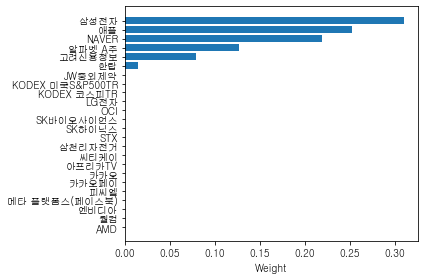

In [76]:
plot_weights(weights)

* back testing

In [ ]:
# weights를 기반으로 transactions이 구해지고
# transaction을 기반으로 postion이 구해지고
# position을 기반을 total return이 구해진다.

In [550]:
# 날짜 세팅
start_date = '1995-05-23'
end_date = '1996-02-23'

start_date = pd.to_datetime(start_date, utc = True)
re_date = start_date
utc_time = [pd.to_datetime(x,utc = True) for x in stock_df.Date]
stock_df.Date = utc_time

In [551]:
loop_time_list = [start_date]
weights_dict = {}

In [552]:
rebalancing_days = {"1Q": 90, "2Q": 180, "3Q": 270, "1Y":365, "2Y":730}

In [553]:
while True:
    end_date = re_date + pd.Timedelta(days = rebalancing_days['1Y'])
    loop_time_list.append(end_date)
    df = stock_df.loc[(stock_df.Date >= start_date) & (stock_df.Date < end_date)]
    df = df.loc[:, ~df.columns.isin(['Date'])]
    
    mean_return = get_return(df, 'mean')
    cs_01 = get_cov(df, opt = 'CovarianceShrinkage-01')

    ef = EfficientFrontier(mean_return, cs_01)
    weights = mvo(ef, 'max_sharpe')
    weights_dict[re_date] = weights
    
    re_date = end_date
    
    if end_date >= utc_time[-1]:
        break

In [555]:
past_weights = {x:0 for x in weights.keys()}
weights = weights_dict[list(weights_dict.keys())[0]]
buy_dict = {x:np.round(z-y, 4) for x,y,z in zip(weights.keys(), past_weights.values(), weights.values())}
past_weights = weights
buy_dict

{'JW중외제약': 0.0,
 'KODEX 미국S&P500TR': 0.0,
 'KODEX 코스피TR': 0.0,
 'LG전자': 0.0,
 'NAVER': 0.0,
 'OCI': 0.0,
 'SK바이오사이언스': 0.0,
 'SK하이닉스': 0.0,
 'STX': 0.0,
 '고려신용정보': 0.0,
 '삼성전자': 0.0,
 '삼천리자전거': 0.0,
 '씨티케이': 0.0,
 '아프리카TV': 0.0,
 '카카오': 0.0,
 '카카오페이': 0.0,
 '피씨엘': 0.0,
 '한탑': 0.0,
 '애플': -0.0,
 '알파벳 A주': 0.0,
 '메타 플랫폼스(페이스북)': 0.0,
 '엔비디아': 0.0,
 '퀄컴': 1.0,
 'AMD': -0.0}

In [135]:
benchmark_rets = bt.benchmark_returns
bt_returns = bt.perf['returns']
bt_positions = bt.positions
bt_transactions = bt.transactions

In [ ]:
# 해당 금액으로 초기 포지션 진입 (금액 / 주가 = 수량)
# 수량 * 일자별 주가의 총 합으로 일자별 총 자산 변동 구하기
# 일자별 총 자산을 통해서 total_returns 구하기

In [136]:
bt_returns.head()

date
2013-01-02 00:00:00+00:00    0.001793
2013-01-03 00:00:00+00:00   -0.003708
2013-01-04 00:00:00+00:00   -0.001469
2013-01-07 00:00:00+00:00    0.000963
2013-01-08 00:00:00+00:00    0.006013
Name: returns, dtype: float64

In [137]:
# index: date
# columns : equities 별 투자 금액 (매수시 + 매도시 -) & cash
bt_positions.head()

column,Equity(QI000000004076 [AABA]),Equity(FIBBG005P7Q881 [AAL]),Equity(FIBBG005P7PXG8 [AALCP]),Equity(FIBBG003PNL136 [AAMC]),Equity(FIBBG000BHJWG1 [AAXN]),Equity(FIBBG0025Y4RY4 [ABBV]),Equity(FIBBG000BN5VZ4 [ABEV]),Equity(FIBBG000C101X4 [ABMD]),Equity(FIBBG000B9ZXB4 [ABT]),Equity(FIBBG000BHG9K0 [ACAD]),...,Equity(FIBBG000FWCC57 [ZIOP]),Equity(FIBBG000BLQVZ5 [ZLC]),Equity(FIBBG001J2P4Y9 [ZLTQ]),Equity(FIBBG000VD6768 [ZNGA]),Equity(FIBBG000BGFWQ6 [ZOLT]),Equity(FIBBG000FTMSF7 [ZQK]),Equity(FIBBG000F9CW36 [ZSL]),Equity(FIBBG0039320N9 [ZTS]),Equity(FIBBG001Z7M393 [ZU]),cash
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,4905.74,...,0.0,0.0,0.0,-4915.38,0.0,0.0,0.0,0.0,0.0,995809.100
2013-01-03 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4964.96,0.0,0.0,-5057.04,4947.58,...,0.0,0.0,0.0,-5019.08,0.0,0.0,-5246.8,0.0,0.0,995584.362
2013-01-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4917.77,0.0,0.0,-5028.16,5182.93,...,0.0,0.0,0.0,-5454.62,0.0,0.0,0.0,0.0,0.0,994047.331
2013-01-07 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4929.21,0.0,0.0,-5066.16,5083.56,...,0.0,0.0,0.0,-5433.88,0.0,0.0,0.0,0.0,0.0,992448.999
2013-01-08 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4821.96,0.0,0.0,-5069.20,5146.32,...,0.0,0.0,0.0,-5174.63,0.0,0.0,0.0,0.0,0.0,992003.832


In [328]:
bt_transactions.loc[bt_transactions.sid == temp_cols[0], :]

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,1046,f7f6bb4aecc14a2b831569fb8a93b56b,4.770,Equity(FIBBG000BHG9K0 [ACAD]),Equity(FIBBG000BHG9K0 [ACAD]),-4989.420
2013-03-13 14:31:00+00:00,-1046,7beb4c98d71a4ba79e4edf8dd02ecfe9,6.209,Equity(FIBBG000BHG9K0 [ACAD]),Equity(FIBBG000BHG9K0 [ACAD]),6494.614
2013-03-22 14:31:00+00:00,668,f78680666e914713865547bdace7e9a1,7.765,Equity(FIBBG000BHG9K0 [ACAD]),Equity(FIBBG000BHG9K0 [ACAD]),-5187.020


In [138]:
# index : date
# amount : 구매 수량
# order_id : 난수
# price : 주당 주가
# sid, symbol : equity name
# txn_dallars : equities 별 투자 금액 (매수 시 음수, 매도 시 양수)
bt_transactions.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [279]:
bt_transactions.loc[(bt_transactions.index == '2013-01-02 15:31:00+00:00') &
                   (bt_transactions.sid in ['Equity(FIBBG000BCJ161 [SRPT])', ''])]

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95
...,...,...,...,...,...,...
2013-01-02 15:31:00+00:00,-157,bb0d82f4fd55406096e76b99a82cac53,31.730,Equity(FIBBG003M3V230 [WES]),Equity(FIBBG003M3V230 [WES]),4981.61
2013-01-02 15:31:00+00:00,-249,b8f4f9d8804a4682bd58e57b8519f5ca,20.000,Equity(FIBBG000NKDGG2 [WMC]),Equity(FIBBG000NKDGG2 [WMC]),4980.00
2013-01-02 15:31:00+00:00,-241,6a33c3a5139f45b5b16ef69f55e668c2,20.660,Equity(FIBBG0027Y18M0 [WP]),Equity(FIBBG0027Y18M0 [WP]),4979.06


In [ ]:
'''
temp_input = total_df.iloc[:, 1:]

mean_return = get_return(temp_input, 'mean')
cs_01 = get_cov(temp_input, opt = 'CovarianceShrinkage-01')

ef = EfficientFrontier(mean_return, cs_01)
weights = mvo(ef, 'max_sharpe')
'''

In [666]:
start_date = '1995-05-23'
end_date = '1996-02-23'

start_date = pd.to_datetime(start_date, utc = True)
end_date = pd.to_datetime(end_date, utc = True)
re_date = start_date
utc_time = [pd.to_datetime(x,utc = True) for x in stock_df.Date]
stock_df.Date = utc_time

In [667]:
# make f_positions
pf_positions = pd.DataFrame({x:[0] for x in stock_df.columns[1:]})
pf_positions['cash'] = initial_amount
pf_positions.index = [end_date - pd.Timedelta(days=1)]
pf_positions

,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,고려신용정보,...,카카오페이,피씨엘,한탑,애플,알파벳 A주,메타 플랫폼스(페이스북),엔비디아,퀄컴,AMD,cash
1996-02-22 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10000000


In [668]:
get_lower = (0, 0)
get_upper = (1, 1)

lower_dict = {"etf" : get_lower[0], "stock" : get_lower[1]}
upper_dict = {"etf" : get_upper[0], "stock" : get_upper[1]}

In [669]:
loop_time_list = [start_date]
weights_dict = {}

In [670]:
while True:
    end_date = re_date + pd.Timedelta(days = 365)
    loop_time_list.append(end_date)
    df = stock_df.loc[(stock_df.Date >= start_date) & (stock_df.Date < end_date)]
    df = df.loc[:, ~df.columns.isin(['Date'])]
    
    # df nan 개수 파악 후 upper_dict, lower_dict 재정의
    
    # 최적화 포트 계산
    mean_return = get_return(df, 'mean')
    cs_01 = get_cov(df, opt = 'CovarianceShrinkage-01')

    ef = EfficientFrontier(mean_return, cs_01)
    #ef.add_sector_constraints(sector_dict, sector_lower=lower_dict, sector_upper=upper_dict)
    weights = mvo(ef, 'max_sharpe')
    weights_dict[end_date] = weights
    
    # 기준 날짜 기준 자산 배분 진행
    
    
    # 
    
    
    
    
    # 날짜 업데이트
    re_date = end_date
    
    if end_date >= utc_time[-1]:
        break

In [ ]:
# weights를 기반으로 transactions이 구해지고
# transaction을 기반으로 postion이 구해지고
# position을 기반을 total return이 구해진다.

In [ ]:
# loop 1

In [662]:
pf_positions

,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,고려신용정보,...,카카오페이,피씨엘,한탑,애플,알파벳 A주,메타 플랫폼스(페이스북),엔비디아,퀄컴,AMD,cash
1996-02-22 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10000000


In [645]:
past_weights = {x:0 for x in weights.keys()}

In [646]:
weights = weights_dict[list(weights_dict.keys())[0]]
buy_dict = {x:np.round(z-y, 4) for x,y,z in zip(weights.keys(), past_weights.values(), weights.values())}
past_weights = weights
buy_dict

{'JW중외제약': 0.0,
 'KODEX 미국S&P500TR': 0.0,
 'KODEX 코스피TR': 0.0,
 'LG전자': 0.0,
 'NAVER': 0.0,
 'OCI': 0.0,
 'SK바이오사이언스': 0.0,
 'SK하이닉스': 0.0,
 'STX': 0.0,
 '고려신용정보': 0.0,
 '삼성전자': 0.0,
 '삼천리자전거': 0.0,
 '씨티케이': 0.0,
 '아프리카TV': 0.0,
 '카카오': 0.0,
 '카카오페이': 0.0,
 '피씨엘': 0.0,
 '한탑': 0.0,
 '애플': -0.0,
 '알파벳 A주': 0.0,
 '메타 플랫폼스(페이스북)': 0.0,
 '엔비디아': 0.0,
 '퀄컴': 1.0,
 'AMD': -0.0}

In [675]:
initial_amount = 10000000

In [676]:
buy_list = []
buy_amt = []

sell_list = []
sell_amt = []

for st_name, percent in buy_dict.items():
    percent = np.round(percent, 4)
    if percent > 0:
        # initial_amount가 value + cash로 바껴야함
        buy_amt.append(np.round(initial_amount * percent, 3))
        buy_list.append(st_name)
    elif percent < 0:
        # initial_amount가 value + cash로 바껴야함
        sell_amt.append(np.round(initial_amount * percent, 3))
        sell_list.append(st_name)
        continue

In [561]:
# weights를 기반으로 transaction을 구해보자
bt_transactions.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [562]:
initial_amount

10000000

In [673]:
start_date
re_date = start_date; re_date

Timestamp('1995-05-23 00:00:00+0000', tz='UTC')

In [674]:
end_date = start_date + pd.Timedelta(days = 365); end_date

Timestamp('1996-05-22 00:00:00+0000', tz='UTC')

In [565]:
df = stock_df.loc[(stock_df.Date >= start_date) & (stock_df.Date < end_date)]
df.head()

,Date,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,...,카카오,카카오페이,피씨엘,한탑,애플,알파벳 A주,메타 플랫폼스(페이스북),엔비디아,퀄컴,AMD
3522,1995-05-23 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,296.8485,NaN,NaN,NaN,1225.4515,13365.794
3523,1995-05-24 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,296.4195,NaN,NaN,NaN,1208.4795,13255.272
3524,1995-05-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,296.3805,NaN,NaN,NaN,1238.7185,12964.747
3525,1995-05-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,289.0090,NaN,NaN,NaN,1224.4855,12929.350
3526,1995-05-30 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,281.1815,NaN,NaN,NaN,1170.3230,12493.578


In [647]:
initial_amount = 10000000

In [648]:
buy_list = []
buy_amt = []

sell_list = []
sell_amt = []

for st_name, percent in buy_dict.items():
    percent = np.round(percent, 4)
    if percent > 0:
        # initial_amount가 value + cash로 바껴야함
        buy_amt.append(np.round(initial_amount * percent, 3))
        buy_list.append(st_name)
    elif percent < 0:
        # initial_amount가 value + cash로 바껴야함
        sell_amt.append(np.round(initial_amount * percent, 3))
        sell_list.append(st_name)
        continue

In [649]:
buy_list

['퀄컴']

In [650]:
buy_amt

[10000000.0]

In [651]:
sell_list

[]

In [652]:
sell_amt

[]

In [ ]:
# 퀄컴을 샀다는 것을 저장하는 df 가 필요 == pf_positions

In [678]:
amount_list = []
order_list = []
price_list = []
sid_list = []
symbol_list = []
txn_list = []

In [679]:
for name, amt in zip(buy_list, buy_amt):
    get_values = get_price(stock_df, re_date, name)
    amount = int(buy_amt[0] / get_values)
    amount_list.append

In [680]:
get_values

1225.4515

In [681]:
amount

8160

In [ ]:
# pcnt_change table도 있어야함

In [682]:
pf_positions

,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,고려신용정보,...,카카오페이,피씨엘,한탑,애플,알파벳 A주,메타 플랫폼스(페이스북),엔비디아,퀄컴,AMD,cash
1996-02-22 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10000000


In [686]:
bt_returns

date
2013-01-02 00:00:00+00:00    0.001793
2013-01-03 00:00:00+00:00   -0.003708
2013-01-04 00:00:00+00:00   -0.001469
2013-01-07 00:00:00+00:00    0.000963
2013-01-08 00:00:00+00:00    0.006013
                               ...   
2013-12-24 00:00:00+00:00   -0.002841
2013-12-26 00:00:00+00:00    0.000688
2013-12-27 00:00:00+00:00   -0.008110
2013-12-30 00:00:00+00:00    0.001283
2013-12-31 00:00:00+00:00   -0.001132
Name: returns, Length: 252, dtype: float64

In [687]:
bt_transactions.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [691]:
bt_positions.head()

column,Equity(QI000000004076 [AABA]),Equity(FIBBG005P7Q881 [AAL]),Equity(FIBBG005P7PXG8 [AALCP]),Equity(FIBBG003PNL136 [AAMC]),Equity(FIBBG000BHJWG1 [AAXN]),Equity(FIBBG0025Y4RY4 [ABBV]),Equity(FIBBG000BN5VZ4 [ABEV]),Equity(FIBBG000C101X4 [ABMD]),Equity(FIBBG000B9ZXB4 [ABT]),Equity(FIBBG000BHG9K0 [ACAD]),...,Equity(FIBBG000FWCC57 [ZIOP]),Equity(FIBBG000BLQVZ5 [ZLC]),Equity(FIBBG001J2P4Y9 [ZLTQ]),Equity(FIBBG000VD6768 [ZNGA]),Equity(FIBBG000BGFWQ6 [ZOLT]),Equity(FIBBG000FTMSF7 [ZQK]),Equity(FIBBG000F9CW36 [ZSL]),Equity(FIBBG0039320N9 [ZTS]),Equity(FIBBG001Z7M393 [ZU]),cash
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,4905.74,...,0.0,0.0,0.0,-4915.38,0.0,0.0,0.0,0.0,0.0,995809.100
2013-01-03 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4964.96,0.0,0.0,-5057.04,4947.58,...,0.0,0.0,0.0,-5019.08,0.0,0.0,-5246.8,0.0,0.0,995584.362
2013-01-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4917.77,0.0,0.0,-5028.16,5182.93,...,0.0,0.0,0.0,-5454.62,0.0,0.0,0.0,0.0,0.0,994047.331
2013-01-07 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4929.21,0.0,0.0,-5066.16,5083.56,...,0.0,0.0,0.0,-5433.88,0.0,0.0,0.0,0.0,0.0,992448.999
2013-01-08 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4821.96,0.0,0.0,-5069.20,5146.32,...,0.0,0.0,0.0,-5174.63,0.0,0.0,0.0,0.0,0.0,992003.832


In [697]:
bt.perf.loc[bt.perf.index == "2013-01-03 00:00:00+00:00"].T

date,2013-01-03 00:00:00+00:00
column,
algorithm_period_return,-0.001922
benchmark_period_return,0.023343
capital_used,-224.738
ending_cash,995584.362
ending_exposure,2493.335
ending_value,2493.335
excess_return,0.0
gross_leverage,0.991728
long_exposure,496157.325


<AxesSubplot:xlabel='date'>

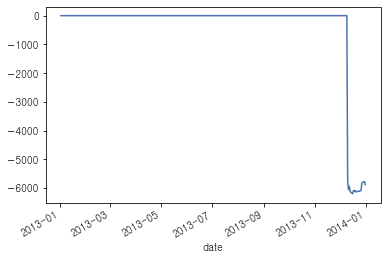

In [685]:
bt_positions['Equity(FIBBG005P7Q881 [AAL])'].plot()

In [580]:
def get_price(df, date, name):
    return df.loc[df.Date == date, name].values[0]

In [612]:
amount = int(buy_amt[0] / get_values)

In [618]:
pf_transactions['amount'] = amount
pf_transactions['price'] = get_values
pf_transactions['sid'] = buy_list[0]
pf_transactions['symbol'] = buy_list[0]
pf_transactions['txn_dollars'] = -amount * get_values

In [619]:
pf_transactions

,amount,order_id,price,sid,symbol,txn_dollars


In [603]:
bt_transactions.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [598]:
# make pf_positions
pf_positions = pd.DataFrame({x:[0] for x in stock_df.columns[1:]})
pf_positions['cash'] = initial_amount
pf_positions.index = [start_date - pd.Timedelta(days=1)]
pf_positions

,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,고려신용정보,...,카카오페이,피씨엘,한탑,애플,알파벳 A주,메타 플랫폼스(페이스북),엔비디아,퀄컴,AMD,cash
1995-05-22 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10000000


In [523]:
weights = weights_dict[list(weights_dict.keys())[1]]
buy_dict = {x:np.round(z-y, 4) for x,y,z in zip(weights.keys(), past_weights.values(), weights.values())}
past_weights = weights
buy_dict

{'JW중외제약': -0.0,
 'KODEX 미국S&P500TR': -0.0,
 'KODEX 코스피TR': -0.0,
 'LG전자': -0.0,
 'NAVER': -0.0,
 'OCI': -0.0,
 'SK바이오사이언스': -0.0,
 'SK하이닉스': -0.0,
 'STX': -0.0,
 '고려신용정보': -0.0,
 '삼성전자': -0.0,
 '삼천리자전거': -0.0,
 '씨티케이': -0.0,
 '아프리카TV': -0.0,
 '카카오': -0.0,
 '카카오페이': -0.0,
 '피씨엘': -0.0,
 '한탑': -0.0,
 '애플': 0.0,
 '알파벳 A주': -0.0,
 '메타 플랫폼스(페이스북)': -0.0,
 '엔비디아': -0.0,
 '퀄컴': -0.1346,
 'AMD': 0.1347}

In [463]:
weights = weights_dict[list(weights_dict.keys())[2]]
buy_dict = {x:np.round(z-y, 4) for x,y,z in zip(weights.keys(), past_weights.values(), weights.values())}
past_weights = weights
buy_dict

{'JW중외제약': 0.0,
 'KODEX 미국S&P500TR': 0.0,
 'KODEX 코스피TR': 0.0,
 'LG전자': 0.0,
 'NAVER': 0.0,
 'OCI': 0.0,
 'SK바이오사이언스': 0.0,
 'SK하이닉스': 0.0,
 'STX': 0.0,
 '고려신용정보': 0.0,
 '삼성전자': 0.0,
 '삼천리자전거': 0.0,
 '씨티케이': 0.0,
 '아프리카TV': 0.0,
 '카카오': 0.0,
 '카카오페이': 0.0,
 '피씨엘': 0.0,
 '한탑': 0.0,
 '애플': 0.0,
 '알파벳 A주': 0.0,
 '메타 플랫폼스(페이스북)': 0.0,
 '엔비디아': 0.0,
 '퀄컴': 0.0435,
 'AMD': -0.0435}

In [464]:
weights = weights_dict[list(weights_dict.keys())[3]]
buy_dict = {x:np.round(z-y, 4) for x,y,z in zip(weights.keys(), past_weights.values(), weights.values())}
past_weights = weights
buy_dict

{'JW중외제약': 0.0,
 'KODEX 미국S&P500TR': 0.0,
 'KODEX 코스피TR': 0.0,
 'LG전자': 0.0,
 'NAVER': 0.0,
 'OCI': 0.0,
 'SK바이오사이언스': 0.0,
 'SK하이닉스': 0.0,
 'STX': 0.4518,
 '고려신용정보': 0.0,
 '삼성전자': 0.0,
 '삼천리자전거': 0.1546,
 '씨티케이': 0.0,
 '아프리카TV': 0.0,
 '카카오': 0.0,
 '카카오페이': 0.0,
 '피씨엘': 0.0,
 '한탑': 0.3861,
 '애플': 0.0009,
 '알파벳 A주': 0.0,
 '메타 플랫폼스(페이스북)': 0.0,
 '엔비디아': 0.0,
 '퀄컴': -0.9935,
 'AMD': 0.0}

In [377]:
initial_amount = 10000000

buy_list = []
buy_amt = []
for st_name, percent in weights.items():
    percent = np.round(percent, 4)
    if percent > 0:
        buy_amt.append(np.round(initial_amount * percent, 3))
        buy_list.append(st_name)
    else:
        continue

In [386]:
bt_transactions.head(2)

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.25,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.82,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12


In [384]:
pf_transactions = pd.DataFrame({x:[] for x in bt_transactions.columns})

In [385]:
pf_transactions

,amount,order_id,price,sid,symbol,txn_dollars


In [132]:
temp_input = stock_df.loc[(stock_df.Date >= start_date) & (stock_df.Date <= end_date), ~stock_df.columns.isin(['Date'])]

In [133]:
mean_return = get_return(temp_input, 'mean')
cs_01 = get_cov(temp_input, opt = 'CovarianceShrinkage-01')

ef = EfficientFrontier(mean_return, S_semi)
ef.add_sector_constraints(sector_dict, sector_lower=lower_dict, sector_upper=upper_dict)
weights = mvo(ef, 'max_sharpe')

In [134]:
weights

OrderedDict([('JW중외제약', 0.0),
             ('KODEX 미국S&P500TR', 0.0),
             ('KODEX 코스피TR', 0.0),
             ('LG전자', 0.0),
             ('NAVER', 0.0),
             ('OCI', 0.0),
             ('SK바이오사이언스', 0.0),
             ('SK하이닉스', 0.0),
             ('STX', 0.0),
             ('고려신용정보', 0.0),
             ('삼성전자', 0.0),
             ('삼천리자전거', 0.0),
             ('씨티케이', 0.0),
             ('아프리카TV', 0.0),
             ('카카오', 0.0),
             ('카카오페이', 0.0),
             ('피씨엘', 0.0),
             ('한탑', 0.0),
             ('애플', 0.0),
             ('알파벳 A주', 0.0),
             ('메타 플랫폼스(페이스북)', 0.0),
             ('엔비디아', 0.0),
             ('퀄컴', 1.0),
             ('AMD', 0.0)])

In [100]:
start_idx = np.where(stock_df.Date == start_date)[0][0]
use_df = stock_df.loc[stock_df.Date >= start_date]

In [110]:
use_df

,Date,JW중외제약,KODEX 미국S&P500TR,KODEX 코스피TR,LG전자,NAVER,OCI,SK바이오사이언스,SK하이닉스,STX,...,카카오,카카오페이,피씨엘,한탑,애플,알파벳 A주,메타 플랫폼스(페이스북),엔비디아,퀄컴,AMD
3522,1995-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,296.8485,NaN,NaN,NaN,1225.4515,13365.7940
3523,1995-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,296.4195,NaN,NaN,NaN,1208.4795,13255.2720
3524,1995-05-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,296.3805,NaN,NaN,NaN,1238.7185,12964.7470
3525,1995-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,289.0090,NaN,NaN,NaN,1224.4855,12929.3500
3526,1995-05-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,281.1815,NaN,NaN,NaN,1170.3230,12493.5780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10586,2022-09-22,18900.0,11835.0,11035.0,85300.0,206500.0,103500.0,89600.0,86000.0,3135.0,...,61300.0,57900.0,11250.0,2200.0,214546.2410,140661.6510,200612.1130,176438.0865,173727.1120,97623.1750
10587,2022-09-23,18300.0,11760.0,10850.0,84900.0,210500.0,98200.0,86200.0,83500.0,3030.0,...,61000.0,55300.0,10450.0,2005.0,214075.4287,140515.9066,199816.0669,178113.9444,172464.2771,96713.1964
10588,2022-09-26,17900.0,11665.0,10505.0,81800.0,204500.0,93300.0,84600.0,82500.0,3935.0,...,59700.0,53000.0,10200.0,1935.0,215718.7006,140459.6726,195115.4686,174955.7784,171321.5972,94860.7140
10589,2022-09-27,17650.0,11700.0,10530.0,81300.0,204500.0,94100.0,85200.0,82000.0,3625.0,...,59300.0,52600.0,10250.0,1835.0,216500.8160,139093.5000,191735.0400,177083.8580,171677.0440,95824.7220


## PYFOLIO

In [47]:
import plotly.express as px

fig =px.scatter(x=range(10), y=range(10))
fig.write_html("file.html")

* only returns

In [ ]:
plot_rolling_returns
plot_returns
plot_annual_returns
plot_monthly_returns_dist
plot_monthly_returns_heatmap
plot_return_quantiles
plot_rolling_beta
plot_rolling_sharpe
plot_drawdown_periods
plot_drawdown_underwater

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


<AxesSubplot:xlabel='date', ylabel='Cumulative returns'>

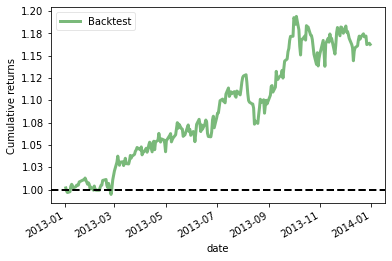

In [19]:
pf.plot_rolling_returns(bt_returns)

<AxesSubplot:xlabel='date', ylabel='Returns'>

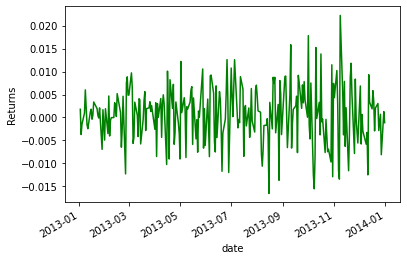

In [20]:
pf.plot_returns(bt_returns)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

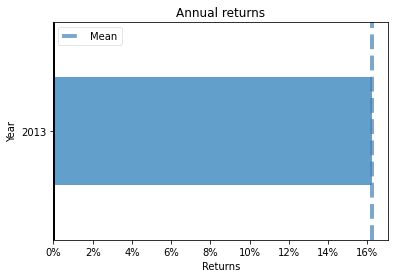

In [21]:
pf.plot_annual_returns(bt_returns)

<AxesSubplot:title={'center':'Distribution of monthly returns'}, xlabel='Returns', ylabel='Number of months'>

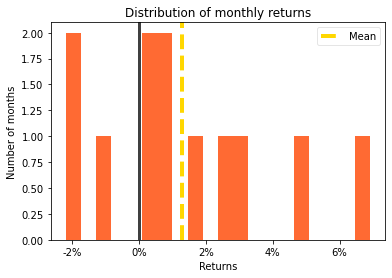

In [22]:
pf.plot_monthly_returns_dist(bt_returns)

<AxesSubplot:title={'center':'Monthly returns (%)'}, xlabel='Month', ylabel='Year'>

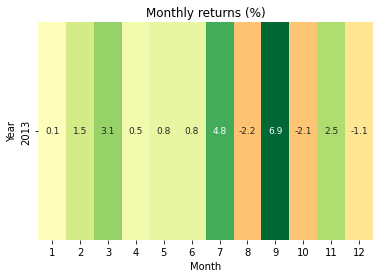

In [23]:
pf.plot_monthly_returns_heatmap(bt_returns)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:xlabel='date'>

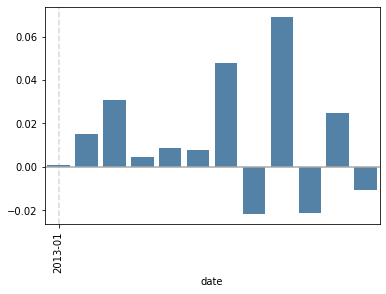

In [24]:
pf.plot_monthly_returns_timeseries(bt_returns)

<AxesSubplot:title={'center':'Return quantiles'}>

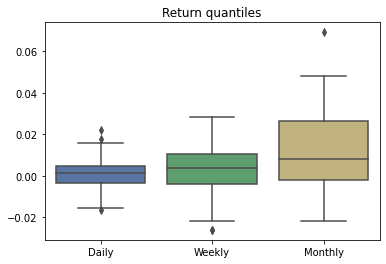

In [25]:
pf.plot_return_quantiles(bt_returns)

<AxesSubplot:>

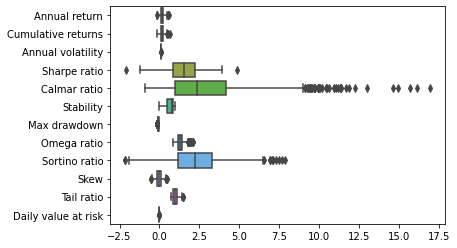

In [39]:
pf.plotting.plot_perf_stats(bt_returns, None)

In [43]:
pf.plotting.show_perf_stats(bt_returns)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2013-01-02
End date,2013-12-31
Total months,12
,Backtest
Annual return,16.3%
Cumulative returns,16.3%
Annual volatility,10.1%
Sharpe ratio,1.54
Calmar ratio,3.31
Stability,0.94
Max drawdown,-4.9%


In [44]:
pf.plotting.show_worst_drawdown_periods(bt_returns, top = 3)

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.91,2013-08-05,2013-08-15,2013-09-10,27
1,4.68,2013-10-04,2013-11-07,NaT,NaN
2,1.98,2013-05-15,2013-06-05,2013-06-10,19


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)


<AxesSubplot:title={'center':'Rolling portfolio beta to benchmark'}, ylabel='Beta'>

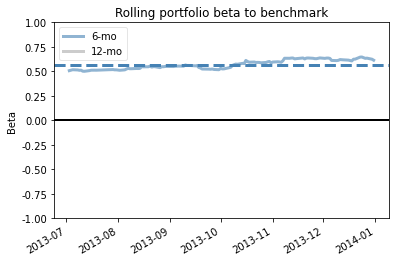

In [34]:
pf.plotting.plot_rolling_beta(bt_returns, benchmark_rets)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=returns.index)


<AxesSubplot:title={'center':'Rolling portfolio beta to benchmark'}, ylabel='Beta'>

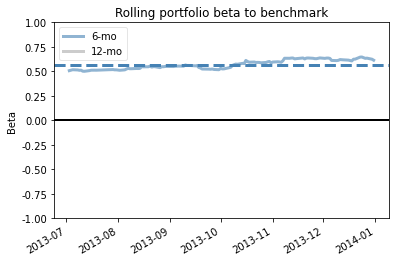

In [27]:
pf.plot_rolling_beta(bt_returns, benchmark_rets)

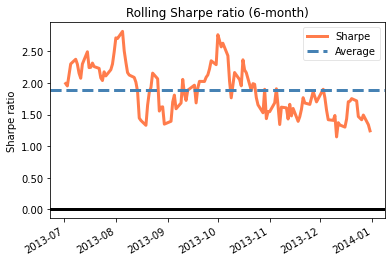

In [28]:
pf.plot_rolling_sharpe(bt_returns);

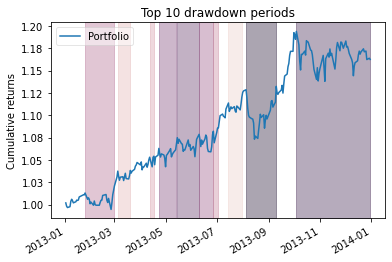

In [29]:
pf.plot_drawdown_periods(bt_returns);

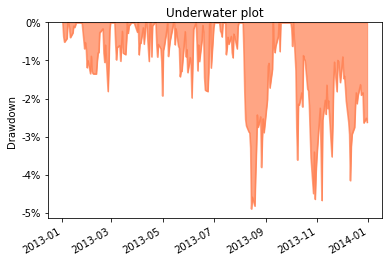

In [30]:
pf.plot_drawdown_underwater(bt_returns);

* pyfolio

In [ ]:
from quantrocket.zipline import ZiplineBacktestResult

import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical

In [2]:
bt = ZiplineBacktestResult.from_csv('https://raw.githubusercontent.com/quantrocket-codeload/quant-finance-lectures/master/quant_finance_lectures/Lecture33-Backtest-Results.csv')

In [3]:
benchmark_rets = bt.benchmark_returns
bt_returns = bt.perf['returns']
bt_positions = bt.positions
bt_transactions = bt.transactions

In [114]:
bt_returns.head()

date
2013-01-02 00:00:00+00:00    0.001793
2013-01-03 00:00:00+00:00   -0.003708
2013-01-04 00:00:00+00:00   -0.001469
2013-01-07 00:00:00+00:00    0.000963
2013-01-08 00:00:00+00:00    0.006013
Name: returns, dtype: float64

In [117]:
bt_transactions.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [119]:
bt_positions.head()

column,Equity(QI000000004076 [AABA]),Equity(FIBBG005P7Q881 [AAL]),Equity(FIBBG005P7PXG8 [AALCP]),Equity(FIBBG003PNL136 [AAMC]),Equity(FIBBG000BHJWG1 [AAXN]),Equity(FIBBG0025Y4RY4 [ABBV]),Equity(FIBBG000BN5VZ4 [ABEV]),Equity(FIBBG000C101X4 [ABMD]),Equity(FIBBG000B9ZXB4 [ABT]),Equity(FIBBG000BHG9K0 [ACAD]),...,Equity(FIBBG000FWCC57 [ZIOP]),Equity(FIBBG000BLQVZ5 [ZLC]),Equity(FIBBG001J2P4Y9 [ZLTQ]),Equity(FIBBG000VD6768 [ZNGA]),Equity(FIBBG000BGFWQ6 [ZOLT]),Equity(FIBBG000FTMSF7 [ZQK]),Equity(FIBBG000F9CW36 [ZSL]),Equity(FIBBG0039320N9 [ZTS]),Equity(FIBBG001Z7M393 [ZU]),cash
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,4905.74,...,0.0,0.0,0.0,-4915.38,0.0,0.0,0.0,0.0,0.0,995809.100
2013-01-03 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4964.96,0.0,0.0,-5057.04,4947.58,...,0.0,0.0,0.0,-5019.08,0.0,0.0,-5246.8,0.0,0.0,995584.362
2013-01-04 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4917.77,0.0,0.0,-5028.16,5182.93,...,0.0,0.0,0.0,-5454.62,0.0,0.0,0.0,0.0,0.0,994047.331
2013-01-07 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4929.21,0.0,0.0,-5066.16,5083.56,...,0.0,0.0,0.0,-5433.88,0.0,0.0,0.0,0.0,0.0,992448.999
2013-01-08 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,-4821.96,0.0,0.0,-5069.20,5146.32,...,0.0,0.0,0.0,-5174.63,0.0,0.0,0.0,0.0,0.0,992003.832


In [14]:
pf.timeseries.annual_return(bt_returns)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3044\1101793606.py:1: DeprecationWarning: Risk functions in pyfolio.timeseries are deprecated and will be removed in a future release. Please install the empyrical package instead.
  pf.timeseries.annual_return(bt_returns)


0.16250917182001

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2013-01-03
End date,2013-12-31
Total months,11
,Backtest
Annual return,16.1%
Cumulative returns,16.0%
Annual volatility,10.1%
Sharpe ratio,1.53
Calmar ratio,3.28
Stability,0.94
Max drawdown,-4.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.91,2013-08-05,2013-08-15,2013-09-10,27
1,4.68,2013-10-04,2013-11-07,NaT,NaN
2,1.98,2013-05-15,2013-06-05,2013-06-10,19
3,1.93,2013-04-23,2013-05-01,2013-05-14,16
4,1.82,2013-06-10,2013-06-24,2013-06-27,14


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:54

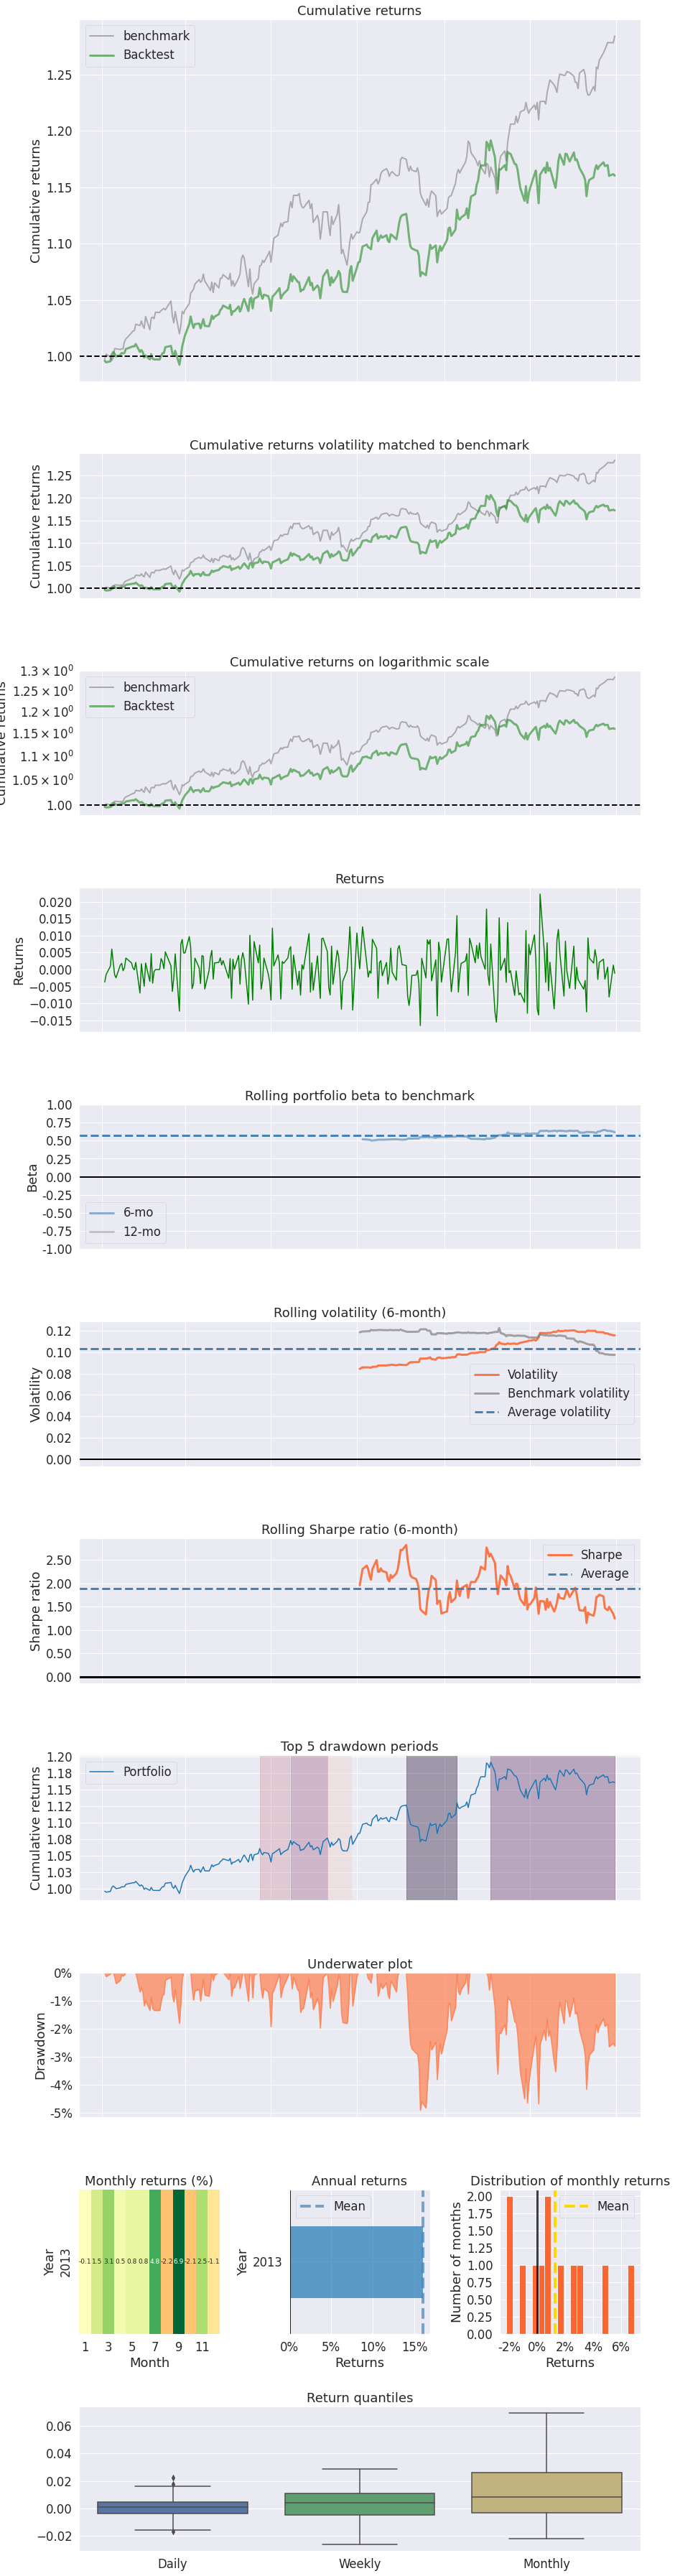

In [13]:
pf.create_returns_tear_sheet(bt_returns,benchmark_rets=benchmark_rets)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2013-01-02
End date,2013-12-31
Total months,12
,Backtest
Annual return,16.2%
Cumulative returns,16.2%
Annual volatility,10.1%
Sharpe ratio,1.54
Calmar ratio,3.31
Stability,0.94
Max drawdown,-4.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.91,2013-08-05,2013-08-15,2013-09-10,27
1,4.68,2013-10-04,2013-11-07,NaT,NaN
2,1.98,2013-05-15,2013-06-05,2013-06-10,19
3,1.93,2013-04-23,2013-05-01,2013-05-14,16
4,1.82,2013-06-10,2013-06-24,2013-06-27,14


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\timeseries.py:12

Stress Events,mean,min,max
New Normal,0.06%,-1.65%,2.22%


Top 10 long positions of all time,max
column,
Equity(FIBBG000K1J931 [CSIQ]),1.78%
Equity(FIBBG000FW8LZ9 [CLDX]),1.75%
Equity(FIBBG000BHG9K0 [ACAD]),1.62%
Equity(FIBBG000R01RJ8 [HIMX]),1.58%
Equity(FIBBG000FVQ185 [SPWR]),1.53%
Equity(FIBBG000PX4P81 [AEGR]),1.50%
Equity(FIBBG000DC3RT4 [SNTS]),1.21%
Equity(FIBBG0015QYC28 [SFUN]),1.16%
Equity(FIBBG000Q72QF9 [JKS]),1.13%


Top 10 short positions of all time,max
column,
Equity(FIBBG001BPFT54 [SCTY]),-1.66%
Equity(FIBBG002NLDLV8 [VIPS]),-1.47%
Equity(FIBBG003T67W19 [XONE]),-1.20%
Equity(FIBBG002CN8XN5 [GOGO]),-1.10%
Equity(FIBBG005915XN3 [VJET]),-0.97%
Equity(FIBBG001M8GFD0 [ONVO]),-0.93%
Equity(FIBBG003H0XV18 [YY]),-0.89%
Equity(FIBBG000PCNTM2 [STRZA]),-0.87%
Equity(FIBBG000NDV1D4 [TMUS]),-0.86%


Top 10 positions of all time,max
column,
Equity(FIBBG000K1J931 [CSIQ]),1.78%
Equity(FIBBG000FW8LZ9 [CLDX]),1.75%
Equity(FIBBG001BPFT54 [SCTY]),1.66%
Equity(FIBBG000BHG9K0 [ACAD]),1.62%
Equity(FIBBG000R01RJ8 [HIMX]),1.58%
Equity(FIBBG000FVQ185 [SPWR]),1.53%
Equity(FIBBG000PX4P81 [AEGR]),1.50%
Equity(FIBBG002NLDLV8 [VIPS]),1.47%
Equity(FIBBG000DC3RT4 [SNTS]),1.21%


C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:1470: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  avg_returns_given_slippage = pd.Series()


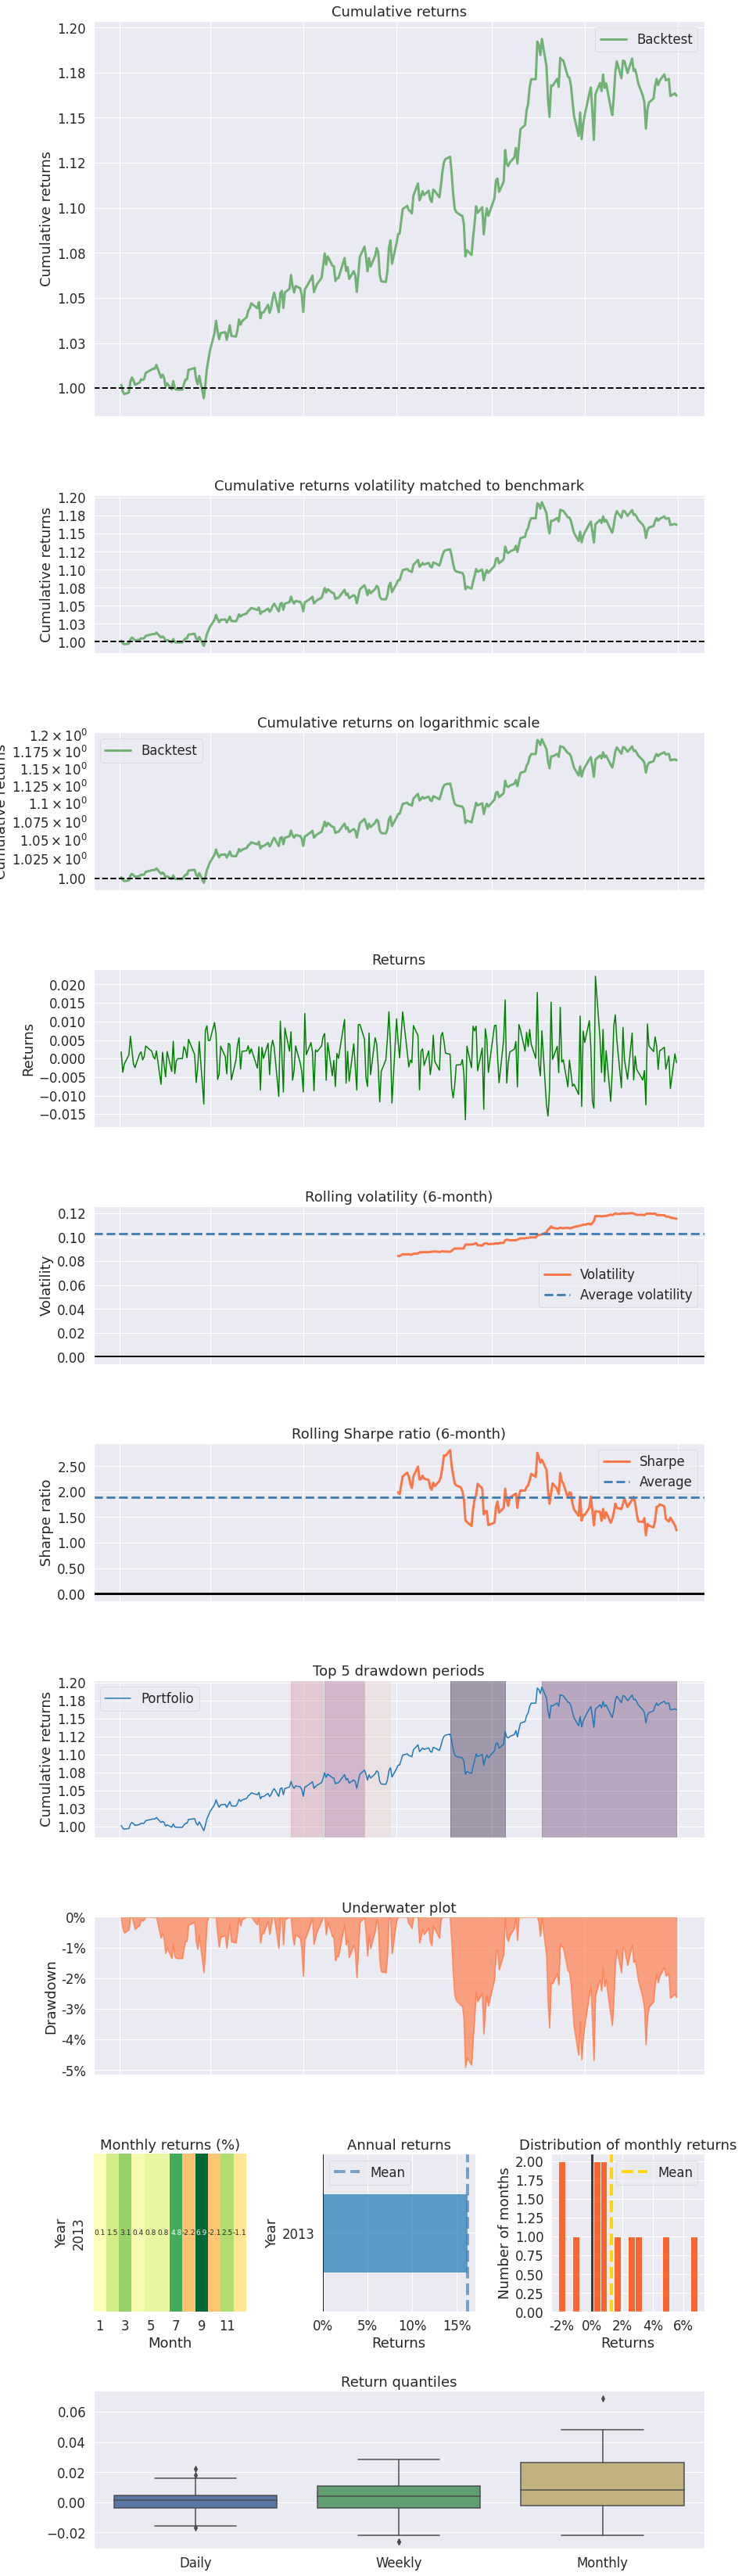

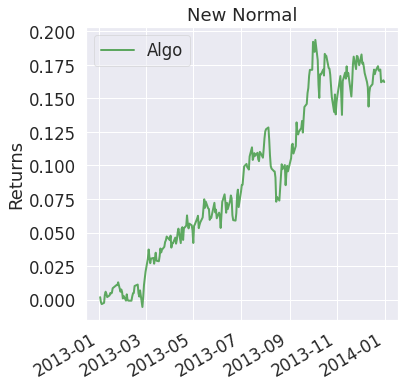

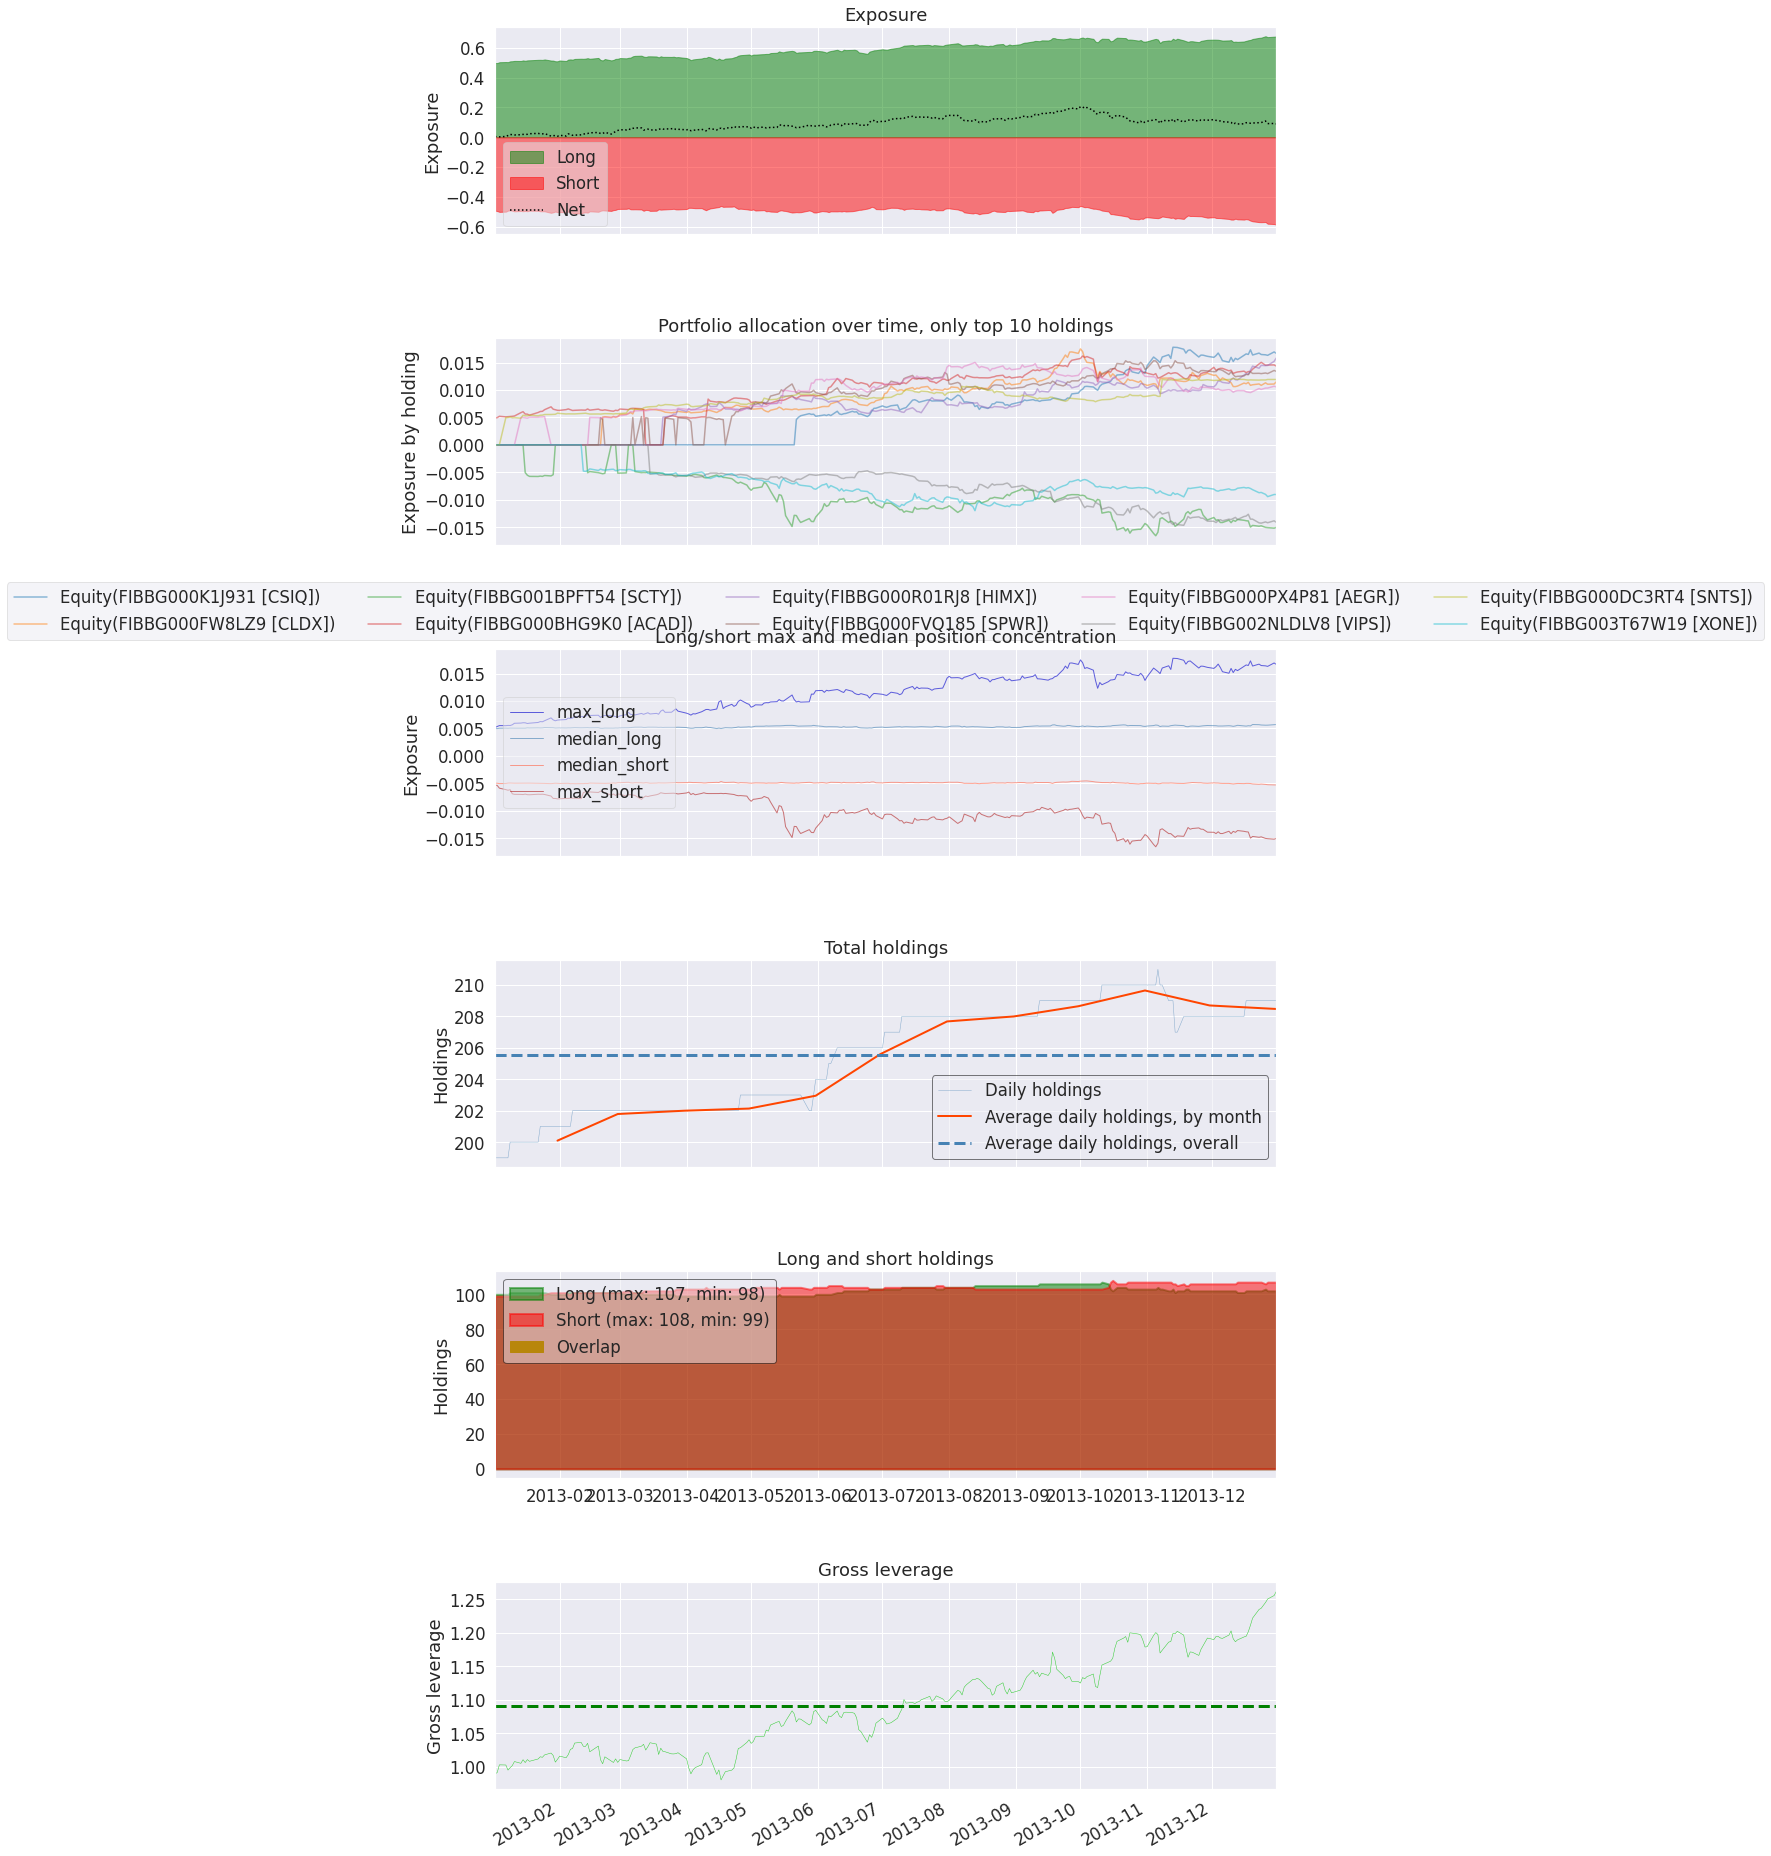

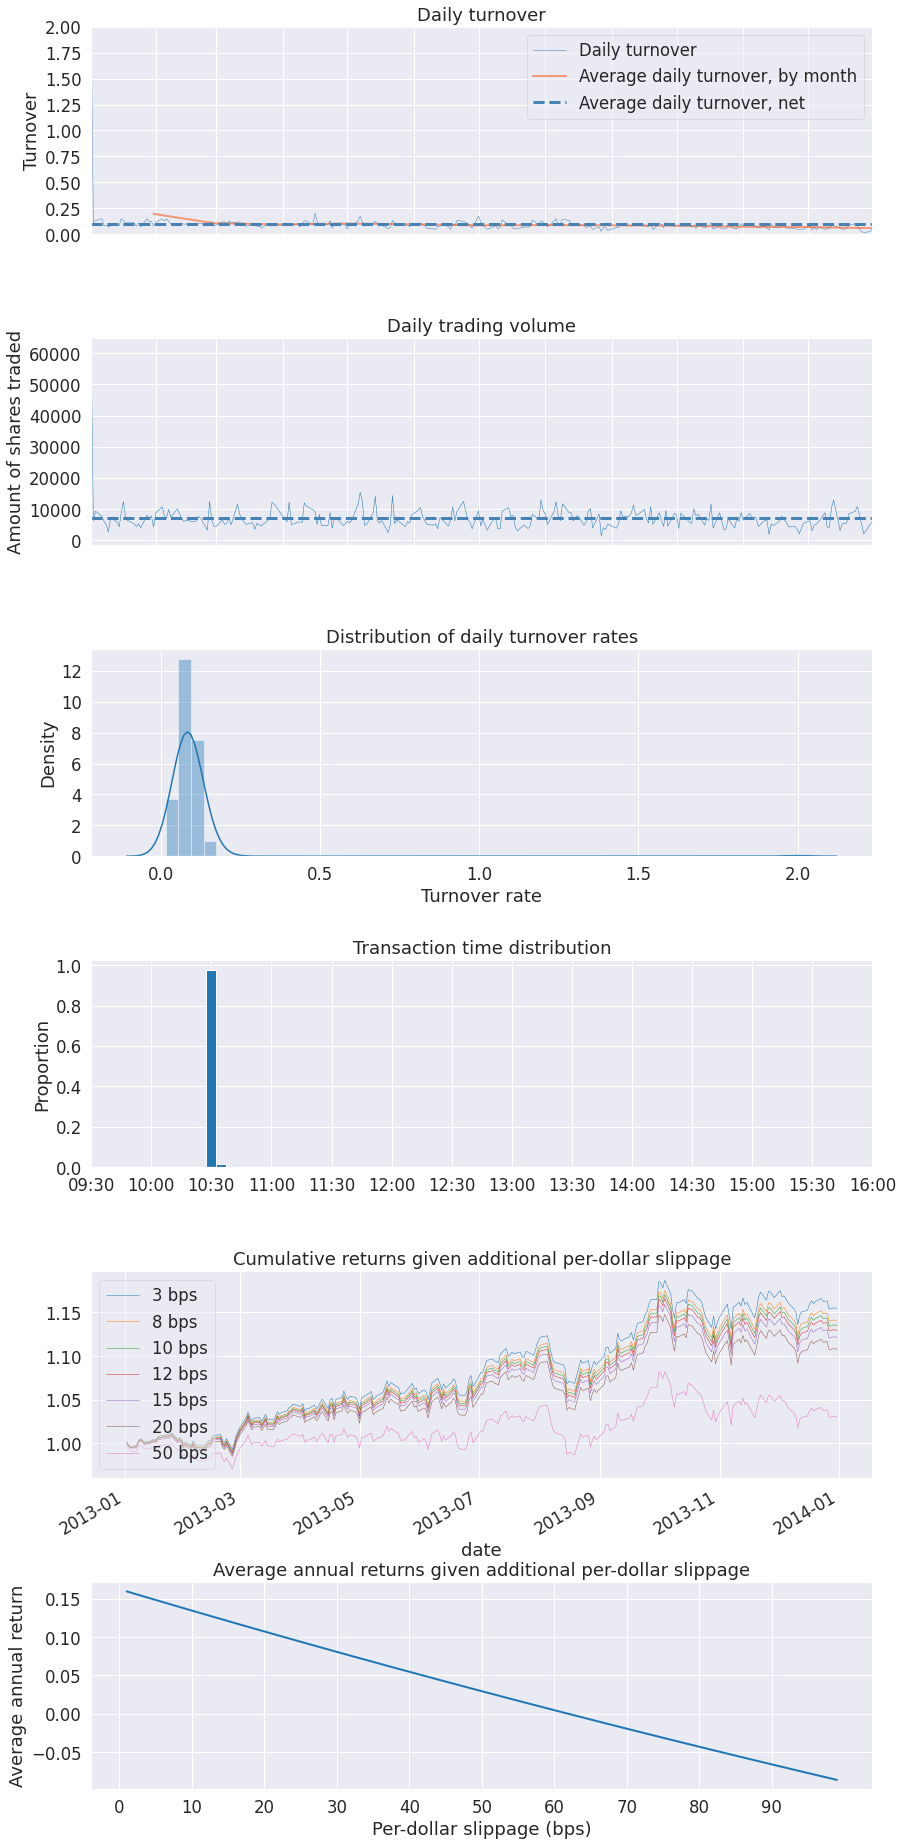

In [6]:
pf.create_full_tear_sheet(bt_returns,
                          positions=bt_positions,
                          transactions=bt_transactions,
                          live_start_date=oos_date,
                          slippage=0.1,
                          sector_mappings=sector_map)

In [19]:
print("The Sharpe Ratio of the backtest is: ", empyrical.sharpe_ratio(bt_returns))

The Sharpe Ratio of the backtest is:  1.543354454834436


In [20]:
print("The market beta of the backtest is: ", empyrical.beta(bt_returns,benchmark_rets))

The market beta of the backtest is:  0.5516223402218898


In [21]:
print("The maxmimum drawdown of the backtest is: ", empyrical.max_drawdown(bt_returns))

The maxmimum drawdown of the backtest is:  -0.04906836872744358


In [146]:
bt_returns.index

DatetimeIndex(['2013-01-02 00:00:00+00:00', '2013-01-03 00:00:00+00:00',
               '2013-01-04 00:00:00+00:00', '2013-01-07 00:00:00+00:00',
               '2013-01-08 00:00:00+00:00', '2013-01-09 00:00:00+00:00',
               '2013-01-10 00:00:00+00:00', '2013-01-11 00:00:00+00:00',
               '2013-01-14 00:00:00+00:00', '2013-01-15 00:00:00+00:00',
               ...
               '2013-12-17 00:00:00+00:00', '2013-12-18 00:00:00+00:00',
               '2013-12-19 00:00:00+00:00', '2013-12-20 00:00:00+00:00',
               '2013-12-23 00:00:00+00:00', '2013-12-24 00:00:00+00:00',
               '2013-12-26 00:00:00+00:00', '2013-12-27 00:00:00+00:00',
               '2013-12-30 00:00:00+00:00', '2013-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=252, freq=None)

In [147]:
benchmark_rets.index

DatetimeIndex(['2013-01-03 00:00:00+00:00', '2013-01-04 00:00:00+00:00',
               '2013-01-07 00:00:00+00:00', '2013-01-08 00:00:00+00:00',
               '2013-01-09 00:00:00+00:00', '2013-01-10 00:00:00+00:00',
               '2013-01-11 00:00:00+00:00', '2013-01-14 00:00:00+00:00',
               '2013-01-15 00:00:00+00:00', '2013-01-16 00:00:00+00:00',
               ...
               '2013-12-17 00:00:00+00:00', '2013-12-18 00:00:00+00:00',
               '2013-12-19 00:00:00+00:00', '2013-12-20 00:00:00+00:00',
               '2013-12-23 00:00:00+00:00', '2013-12-24 00:00:00+00:00',
               '2013-12-26 00:00:00+00:00', '2013-12-27 00:00:00+00:00',
               '2013-12-30 00:00:00+00:00', '2013-12-31 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=251, freq=None)

C:\Windows\python_windows\python_base_env\python-3.8.9.amd64\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


<AxesSubplot:xlabel='date', ylabel='Cumulative returns'>

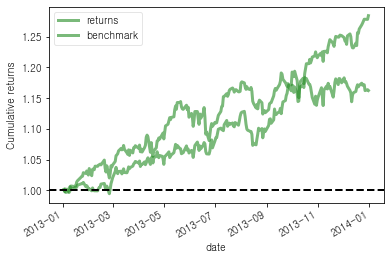

In [274]:
pf.plotting.plot_rolling_returns(pd.concat([bt_returns, benchmark_rets], axis = 1))

In [ ]:
# Cumulative Returns
plt.subplot(2,1,1)
pf.plotting.plot_rolling_returns(bt_returns[:-1], benchmark_rets)

In [ ]:
# Daily, Non-Cumulative Returns
plt.subplot(2,1,2)
pf.plotting.plot_returns(bt_returns)
plt.tight_layout()

In [81]:
# how to calculate?
# benchmark_period_return == s&p500 return인지 봐보자
bt.perf

column,algorithm_period_return,benchmark_period_return,capital_used,ending_cash,ending_exposure,ending_value,excess_return,gross_leverage,long_exposure,long_value,...,starting_value,trading_days,transactions,treasury_period_return,algo_volatility,alpha,benchmark_volatility,beta,sharpe,sortino
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02 00:00:00+00:00,0.001793,0.025633,-4190.9000,9.958091e+05,5983.565,5983.565,0.0,0.989466,498611.709,498611.709,...,0.000,1,"[{'amount': 190, 'dt': Timestamp('2013-01-02 1...",0.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03 00:00:00+00:00,-0.001922,0.023343,-224.7380,9.955844e+05,2493.335,2493.335,0.0,0.991728,496157.325,496157.325,...,5983.565,2,"[{'amount': -185, 'dt': Timestamp('2013-01-03 ...",0.0,0.061748,-0.561676,0.312781,0.197417,-3.908968,-5.798630
2013-01-04 00:00:00+00:00,-0.003388,0.027808,-1537.0310,9.940473e+05,2564.594,2564.594,0.0,1.003104,501135.227,501135.227,...,2493.335,3,"[{'amount': -81, 'dt': Timestamp('2013-01-04 1...",0.0,0.043913,-0.513482,0.231168,0.186601,-6.473649,-7.776581
2013-01-07 00:00:00+00:00,-0.002428,0.024998,-1598.3320,9.924490e+05,5122.731,5122.731,0.0,1.002880,502783.826,502783.826,...,2564.594,4,"[{'amount': -108, 'dt': Timestamp('2013-01-07 ...",0.0,0.039510,-0.282244,0.211377,0.113438,-3.860633,-4.818195
2013-01-08 00:00:00+00:00,0.003570,0.022045,-445.1670,9.920038e+05,11566.590,11566.590,0.0,0.995215,505167.396,505167.396,...,5122.731,5,"[{'amount': 136, 'dt': Timestamp('2013-01-08 1...",0.0,0.058126,0.171992,0.194213,0.019966,3.114668,6.393692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-24 00:00:00+00:00,0.171033,0.304667,-4137.7850,1.056067e+06,114965.902,114965.902,0.0,1.236909,781713.563,781713.563,...,114164.417,248,"[{'amount': 263, 'dt': Timestamp('2013-12-24 1...",0.0,0.101290,0.019757,0.111683,0.527934,1.634817,2.465909
2013-12-26 00:00:00+00:00,0.171839,0.311264,-11688.5804,1.044378e+06,127460.635,127460.635,0.0,1.245473,793477.325,793477.325,...,114965.902,249,"[{'amount': -71, 'dt': Timestamp('2013-12-26 1...",0.0,0.101086,0.017824,0.111529,0.527271,1.638437,2.471349
2013-12-27 00:00:00+00:00,0.162336,0.311193,11775.3510,1.056153e+06,106182.080,106182.080,0.0,1.250686,779949.625,779949.625,...,127460.635,250,"[{'amount': -1271, 'dt': Timestamp('2013-12-27...",0.0,0.101266,0.009278,0.111311,0.528045,1.548258,2.327000


In [262]:
1922/1000000

0.001922

In [270]:
-3714.968/1001792.665

-0.003708320224125418

In [26]:
# pnl, portfolio_value

In [40]:
df = bt.perf.loc[bt.perf.index == '2013-01-04 00:00:00+00:00'].loc[:, ['returns', 'pnl', 'portfolio_value']]
df

column,returns,pnl,portfolio_value
date,,,
2013-01-04 00:00:00+00:00,-0.001469,-1465.772,996611.925


In [41]:
a = (df.portfolio_value - df.pnl).values[0]
b = df.pnl
b/a

date
2013-01-04 00:00:00+00:00   -0.001469
Name: pnl, dtype: float64

In [247]:
bt.perf.columns

Index(['algorithm_period_return', 'benchmark_period_return', 'capital_used',
       'ending_cash', 'ending_exposure', 'ending_value', 'excess_return',
       'gross_leverage', 'long_exposure', 'long_value', 'longs_count',
       'max_drawdown', 'max_leverage', 'net_leverage', 'orders',
       'period_close', 'period_label', 'period_open', 'pnl', 'portfolio_value',
       'positions', 'returns', 'short_exposure', 'short_value', 'shorts_count',
       'starting_cash', 'starting_exposure', 'starting_value', 'trading_days',
       'transactions', 'treasury_period_return', 'algo_volatility', 'alpha',
       'benchmark_volatility', 'beta', 'sharpe', 'sortino'],
      dtype='object', name='column')

In [68]:
bt_returns

date
2013-01-02 00:00:00+00:00    0.001793
2013-01-03 00:00:00+00:00   -0.003708
2013-01-04 00:00:00+00:00   -0.001469
2013-01-07 00:00:00+00:00    0.000963
2013-01-08 00:00:00+00:00    0.006013
                               ...   
2013-12-24 00:00:00+00:00   -0.002841
2013-12-26 00:00:00+00:00    0.000688
2013-12-27 00:00:00+00:00   -0.008110
2013-12-30 00:00:00+00:00    0.001283
2013-12-31 00:00:00+00:00   -0.001132
Name: returns, Length: 252, dtype: float64

In [ ]:
benchmark_rets = bt.benchmark_returns
bt_returns = bt.perf['returns']
bt_positions = bt.positions
bt_transactions = bt.transactions

In [231]:
benchmark_rets

date
2013-01-03 00:00:00+00:00   -0.002232
2013-01-04 00:00:00+00:00    0.004363
2013-01-07 00:00:00+00:00   -0.002734
2013-01-08 00:00:00+00:00   -0.002881
2013-01-09 00:00:00+00:00    0.002547
                               ...   
2013-12-24 00:00:00+00:00    0.002191
2013-12-26 00:00:00+00:00    0.005057
2013-12-27 00:00:00+00:00   -0.000054
2013-12-30 00:00:00+00:00   -0.000136
2013-12-31 00:00:00+00:00    0.004733
Name: benchmark, Length: 251, dtype: float64

In [237]:
a = bt_transactions.loc[bt_transactions.index == '2013-01-02 15:31:00+00:00']

In [238]:
a.head()

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.250,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.50
2013-01-02 15:31:00+00:00,166,edba92dff732476d9e3aba9e35eb303a,29.820,Equity(FIBBG000D32LR0 [ELLI]),Equity(FIBBG000D32LR0 [ELLI]),-4950.12
2013-01-02 15:31:00+00:00,686,93eb9f2de1d943c18409410ebecaf12e,7.260,Equity(FIBBG000BLCBN7 [HOV]),Equity(FIBBG000BLCBN7 [HOV]),-4980.36
2013-01-02 15:31:00+00:00,602,42cf80c523944a32a07c710171b90586,8.320,Equity(FIBBG000BJJGT8 [CLSN]),Equity(FIBBG000BJJGT8 [CLSN]),-5008.64
2013-01-02 15:31:00+00:00,550,fd972a3386374c03a25ab8d3821d9c03,9.089,Equity(FIBBG000BKXBV7 [ARNA]),Equity(FIBBG000BKXBV7 [ARNA]),-4998.95


In [80]:
a.groupby("sid")['amount'].sum()

sid
Equity(FIBBG000B9WJ73 [ARCH])    -681
Equity(FIBBG000BB2KW0 [APOL])    -237
Equity(FIBBG000BB8ZF0 [WNR])      176
Equity(FIBBG000BB9RZ5 [SHAW])     106
Equity(FIBBG000BBQCY0 [AMD])    -1992
                                 ... 
Equity(FIBBG00FZYFVC5 [DK])       192
Equity(FIBBG00JPR7Y81 [HPR])     -280
Equity(FIBBG00JSKYMY0 [BSMX])    -306
Equity(FIBBG00NNG33D4 [GTAT])   -1545
Equity(QI000000052980 [LGF])      295
Name: amount, Length: 189, dtype: int64

In [249]:
a.txn_dollars.sum() / 995809.1

-0.03408385101120299

In [65]:
bt_transactions.loc[bt_transactions.symbol == 'Equity(FIBBG000BCJ161 [SRPT])']

column,amount,order_id,price,sid,symbol,txn_dollars
date,,,,,,
2013-01-02 15:31:00+00:00,190,f57ddbebc37144d98c8f491825ffd759,26.25,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),-4987.5
2013-10-07 14:31:00+00:00,-190,6820a600b4ca4bb0bd99cf8097827a74,54.04,Equity(FIBBG000BCJ161 [SRPT]),Equity(FIBBG000BCJ161 [SRPT]),10267.6


In [67]:
190*26.25

4987.5

In [66]:
bt_positions.loc[:, ['Equity(FIBBG000BCJ161 [SRPT])']]

column,Equity(FIBBG000BCJ161 [SRPT])
date,
2013-01-02 00:00:00+00:00,4987.5
2013-01-03 00:00:00+00:00,5348.5
2013-01-04 00:00:00+00:00,5496.7
2013-01-07 00:00:00+00:00,5492.9
2013-01-08 00:00:00+00:00,5363.7
...,...
2013-12-24 00:00:00+00:00,0.0
2013-12-26 00:00:00+00:00,0.0
2013-12-27 00:00:00+00:00,0.0
